In [1]:
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import StructType, StructField, DoubleType, StringType, IntegerType
from lifelines import KaplanMeierFitter, CoxPHFitter, WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter
from lifelines.statistics import proportional_hazard_test, pairwise_logrank_test
from lifelines.utils import median_survival_times
from ipywidgets import widgets, interact

In [2]:
spark = SparkSession.builder \
        .config('survival analysis', 4040) \
        .appName("SurvivalAnalysis") \
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/13 16:06:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/13 16:06:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [20]:
# 目标：读取原始数据，定义数据模式，进行基础清洗和列重命名

bronze_df = (
    spark.read
    # 定义数据模式
    .schema(StructType([
        StructField('customerID', StringType()),
        StructField('gender', StringType()),
        StructField('seniorCitizen', DoubleType()),
        StructField('partner', StringType()),
        StructField('dependents', StringType()),
        StructField('tenure', DoubleType()),
        StructField('phoneService', StringType()),
        StructField('multipleLines', StringType()),
        StructField('InternetService', StringType()),
        StructField('onlineSecurity', StringType()),
        StructField('onlineBackup', StringType()),
        StructField('deviceProtection', StringType()),
        StructField('techSupport', StringType()),
        StructField('streamingTV', StringType()),
        StructField('streamingMovies', StringType()),
        StructField('Contract', StringType()),
        StructField('paperlessBilling', StringType()),
        StructField('paymentMethod', StringType()),
        StructField('monthlyCharges', DoubleType()),
        StructField('totalCharges', DoubleType()),
        StructField('Churn', StringType())
    ]))
    # 数据读取配置
    .option('header', 'true')
    .csv("data.txt")
    .select(
        '*',
        col('InternetService').alias('internet_service'),
        col('Contract').alias('contract'),
        col('Churn').alias('churn_string')
    )
    .drop('InternetService', 'Contract', 'Churn')
)


# 数据清洗，特征工程，聚焦分析月付合同且有互联网服务的客户
silver_df = (
    bronze_df
    # 创建数值型流失标签
    .withColumn('churn', 
               when(col('churn_string') == 'Yes', 1).otherwise(0))
    
    .filter(
        (col('contract') == 'Month-to-month') & 
        (col('internet_service') != 'No')
    )
    .drop('churn_string')
)

# 转换并统一列名为小写
telco_pd = (
    silver_df
    .toPandas()  # 转换为Pandas DataFrame（适合小规模数据）
    .rename(columns=str.lower)  # 全部列名转为小写（规范命名）
)

telco_pd

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internet_service,churn
0,7590-VHVEG,Female,0.0,Yes,No,1.0,No,No phone service,No,Yes,No,No,No,No,Yes,Electronic check,29.85,29.85,DSL,0
1,3668-QPYBK,Male,0.0,No,No,2.0,Yes,No,Yes,Yes,No,No,No,No,Yes,Mailed check,53.85,108.15,DSL,1
2,9237-HQITU,Female,0.0,No,No,2.0,Yes,No,No,No,No,No,No,No,Yes,Electronic check,70.70,151.65,Fiber optic,1
3,9305-CDSKC,Female,0.0,No,No,8.0,Yes,Yes,No,No,Yes,No,Yes,Yes,Yes,Electronic check,99.65,820.50,Fiber optic,1
4,1452-KIOVK,Male,0.0,No,Yes,22.0,Yes,Yes,No,Yes,No,No,Yes,No,Yes,Credit card (automatic),89.10,1949.40,Fiber optic,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3346,9767-FFLEM,Male,0.0,No,No,38.0,Yes,No,No,No,No,No,No,No,Yes,Credit card (automatic),69.50,2625.25,Fiber optic,0
3347,0639-TSIQW,Female,0.0,No,No,67.0,Yes,Yes,Yes,Yes,Yes,No,Yes,No,Yes,Credit card (automatic),102.95,6886.25,Fiber optic,1
3348,8456-QDAVC,Male,0.0,No,No,19.0,Yes,No,No,No,No,No,Yes,No,Yes,Bank transfer (automatic),78.70,1495.10,Fiber optic,0
3349,4801-JZAZL,Female,0.0,Yes,Yes,11.0,No,No phone service,Yes,No,No,No,No,No,Yes,Electronic check,29.60,346.45,DSL,0


np.float64(34.0)

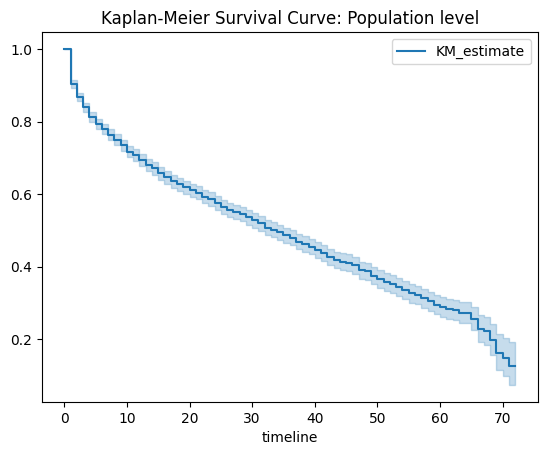

In [4]:
telco_pd = silver_df.toPandas()
# 初始化Kaplan-Meier估计器
kmf = KaplanMeierFitter()
T = telco_pd['tenure']  # 持续时间序列
C = telco_pd['churn'].astype(float) # 事件观察序列
kmf.fit(T,C) # 拟合Kaplan-Meier生存曲线
kmf.plot(title='Kaplan-Meier Survival Curve: Population level')
# 计算并标注中位生存时间
kmf.median_survival_time_

In [5]:
def plot_km(col):
    ax = plt.subplot(111)
    for r in telco_pd[col].unique():
        ix = telco_pd[col] == r
        KaplanMeierFitter().fit(
            telco_pd['tenure'][ix], 
            telco_pd['churn'][ix],
            label=r
        ).plot(ax=ax)

def print_logrank(col):
    return pairwise_logrank_test(
        telco_pd['tenure'],
        telco_pd[col],
        telco_pd['churn']
    ).summary

def get_survival_probs(col, val):
    mask = telco_pd[col] == val
    return KaplanMeierFitter().fit(
        telco_pd['tenure'][mask],
        telco_pd['churn'][mask]
    )

sp_internet_dsl = get_survival_probs('internet_service', 'DSL')
pd.DataFrame(sp_internet_dsl.survival_function_at_times(range(0,10)))

,KM_estimate
0,1.000000
1,0.902698
2,0.864380
3,0.834702
4,0.810522
5,0.794352
6,0.783900
7,0.776362
8,0.768486
9,0.750833


,,test_statistic,p,-log2(p)
Female,Male,2.038938,0.153317,2.705414


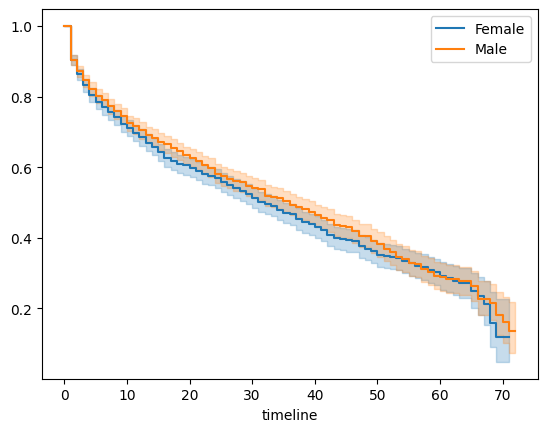

In [6]:
plot_km('gender')
print_logrank('gender')

In [7]:
encode_cols = ['dependents','internet_service','onlineBackup','techSupport','paperlessBilling']
encoded_pd = pd.get_dummies(telco_pd,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=False)
encoded_pd.head()
survival_pd = encoded_pd[['churn','tenure','dependents_Yes','internet_service_DSL','onlineBackup_Yes','techSupport_Yes']]
survival_pd.loc[:,'churn'] = survival_pd.loc[:,'churn'].astype('float')
cph = CoxPHFitter(alpha=0.05)
cph.fit(survival_pd, 'tenure', 'churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 3351 total observations, 1795 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 3351
number of events observed = 1556
   partial log-likelihood = -11315.95
         time fit was run = 2025-04-13 16:06:35 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
dependents_Yes       -0.33      0.72      0.07           -0.47           -0.19                0.63                0.83
internet_service_DSL -0.22      0.80      0.06           -0.33           -0.10                0.72                0.90
onlineBackup_Yes     -0.78      0.46      0.06           -0.89           -0.66                0.41                0.52
techSupport_Yes      -0.64      0.53      0.08           -0.79           -0.49                0.46                0.61

                      cmp to      z      p  -log2(p)
covariate                                           
dependents_Yes          0.00  -4.64 <0.005     18.12
internet_service_DSL    0.00  -3.68 <0.005     12.07
onlineBackup_Yes        0.00 -13.13 <0.005    128.37
techSupport_Yes         0.00  -8.48 <0.005     55.36
---
Concordance = 0.64
Partial AIC = 22639.90
log-likelihood ratio test = 337.77 on 4 df
-log2(p) of ll-ratio test = 236.24


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3351 total observations, 1795 right-censored observations>
         test_name = proportional_hazard_test

---
                           test_statistic      p  -log2(p)
dependents_Yes       km              1.48   0.22      2.16
                     rank            0.81   0.37      1.44
internet_service_DSL km             20.98 <0.005     17.72
                     rank           26.71 <0.005     22.01
onlineBackup_Yes     km             17.80 <0.005     15.31
                     rank           17.47 <0.005     15.07
techSupport_Yes      km              8.09 <0.005      7.81
                     rank           13.76 <0.005     12.23



1. Variable 'internet_service_DSL' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['internet_service_DSL',
...]` in the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'onlineBackup_Yes' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['onlineBackup_Yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


3. Variable 'techSupport_Yes' failed the non-proportional test: p-value is 0.0002.

   Advice: with so few unique values (only 2), you can include `strata=['techSupport_Yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/l

[[<Axes: xlabel='rank-transformed time\n(p=0.3680)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2232)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0002)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0044)'>]]

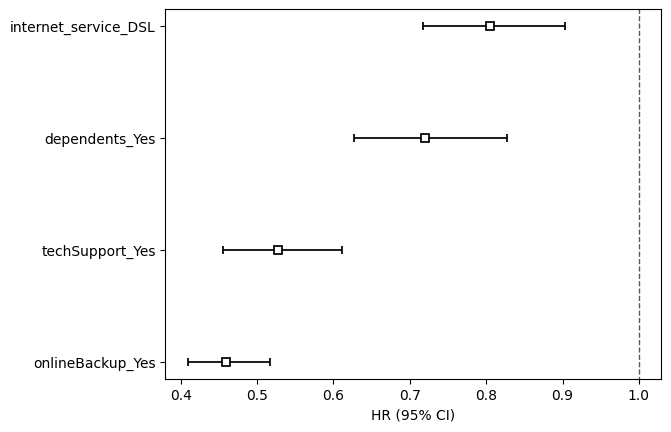

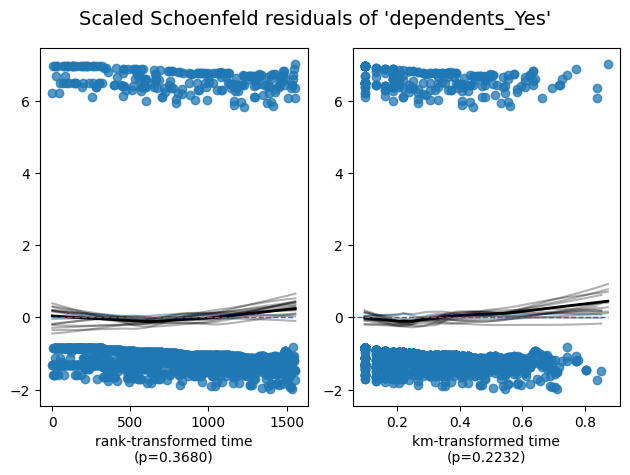

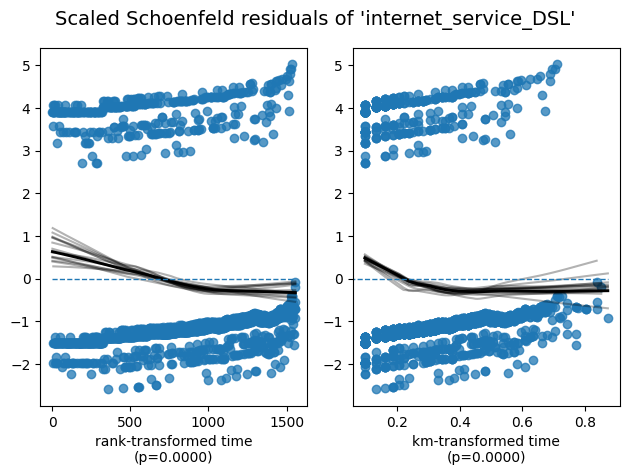

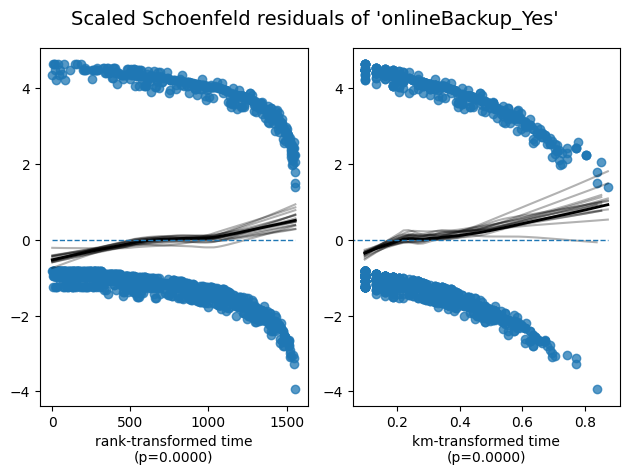

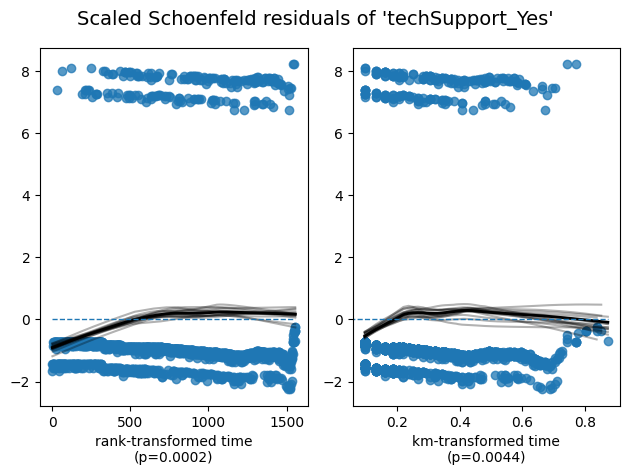

In [8]:
cph.plot(hazard_ratios=True)
cph.check_assumptions(survival_pd,p_value_threshold=0.05,show_plots=True)

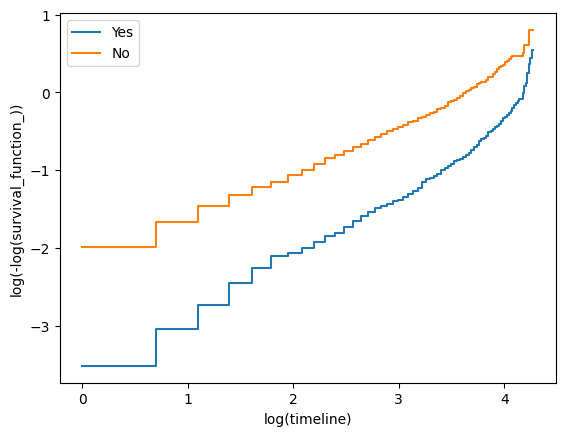

In [19]:
kmf = KaplanMeierFitter()

T=telco_pd['tenure'] #时间列
C=telco_pd['churn'].astype(float)

kmf.fit(T,C)
def plot_km_loglog(col):
  ax = plt.subplot(111)
  for r in telco_pd[col].unique():
    ix = telco_pd[col] == r 
    kmf.fit(T[ix], C[ix],label=r)
    kmf.plot_loglogs(ax=ax)


plot_km_loglog('onlineBackup')

Median Survival Time: 135.51 months


<lifelines.LogLogisticAFTFitter: fitted with 3351 total observations, 1795 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
   number of observations = 3351
number of events observed = 1556
           log-likelihood = -6838.360
         time fit was run = 2025-04-13 16:19:26 UTC

---
                                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                                                
alpha_ deviceProtection_Yes                    0.484     1.623     0.070           0.346           0.622               1.414               1.863
       internet_service_DSL                    0.384     1.468     0.077           0.233           0.535               1.262               1.707
       multipleLines_Yes                       0.663     1.940     0.069           0.528           0.798               1.696               2.220
       onlineBackup_Yes                        0.813     2.254     0.070           0.676           0.950               1.966               2.585
       onlineSecurity_Yes                      0.862     2.367     0.085           0.695           1.028               2.003               2.797
       partner_Yes                             0.677     1.968     0.066           0.547           0.807               1.728               2.240
       paymentMethod_Bank transfer (automatic) 0.740     2.096     0.092           0.560           0.920               1.750               2.509
       paymentMethod_Credit card (automatic)   0.799     2.223     0.096           0.612           0.986               1.844               2.682
       techSupport_Yes                         0.689     1.992     0.087           0.518           0.860               1.679               2.364
       Intercept                               1.591     4.909     0.065           1.464           1.719               4.322               5.576
beta_  Intercept                               0.118     1.125     0.021           0.078           0.159               1.081               1.172

                                                cmp to      z       p  -log2(p)
param  covariate                                                               
alpha_ deviceProtection_Yes                      0.000  6.877 <0.0005    37.252
       internet_service_DSL                      0.000  4.981 <0.0005    20.595
       multipleLines_Yes                         0.000  9.644 <0.0005    70.695
       onlineBackup_Yes                          0.000 11.634 <0.0005   101.504
       onlineSecurity_Yes                        0.000 10.123 <0.0005    77.599
       partner_Yes                               0.000 10.213 <0.0005    78.929
       paymentMethod_Bank transfer (automatic)   0.000  8.047 <0.0005    50.071
       paymentMethod_Credit card (automatic)     0.000  8.359 <0.0005    53.809
       techSupport_Yes                           0.000  7.902 <0.0005    48.368
       Intercept                                 0.000 24.470 <0.0005   436.877
beta_  Intercept                                 0.000  5.713 <0.0005    26.423
---
Concordance = 0.731
AIC = 13698.720
log-likelihood ratio test = 877.488 on 9 df
-log2(p) of ll-ratio test = 605.782

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

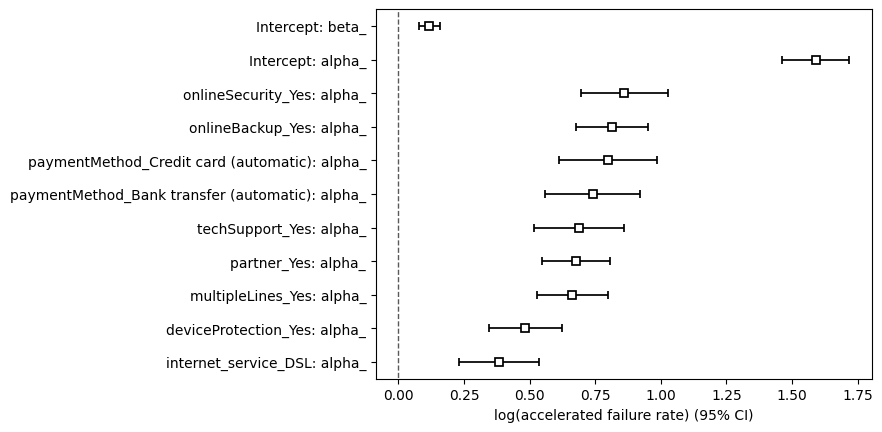

In [17]:
# 需要独热编码的分类变量列表
encode_cols = [
    'partner', 'multipleLines', 'internet_service',
    'onlineSecurity', 'onlineBackup', 'deviceProtection',
    'techSupport', 'paymentMethod'
]

# 执行独热编码
encoded_pd = pd.get_dummies(
    telco_pd,
    columns=encode_cols,
    prefix=encode_cols,
    drop_first=False
)

# 查看编码后的数据前五行
encoded_pd.head()

# 选择用于加速失效时间模型的特征：
survival_pd = encoded_pd[[
    'churn', 'tenure',
    'partner_Yes',
    'multipleLines_Yes',
    'internet_service_DSL',
    'onlineSecurity_Yes',
    'onlineBackup_Yes',
    'deviceProtection_Yes',
    'techSupport_Yes',
    'paymentMethod_Bank transfer (automatic)',
    'paymentMethod_Credit card (automatic)'
]]


# 初始化Log-Logistic加速失效时间模型
aft = LogLogisticAFTFitter()
# 模型拟合
aft.fit(
    survival_pd, 
    duration_col='tenure',  # 生存时间列
    event_col='churn'       # 事件发生指示列（1表示流失）
)
# 输出中位生存时间
# 指数转换：因为模型在log尺度上拟合
print("Median Survival Time: {:.2f} months".format(
    np.exp(aft.median_survival_time_)
))

# 打印模型摘要：
aft.print_summary(decimals=3)  # 控制小数位数

# 可视化系数及其置信区间：
aft.plot()

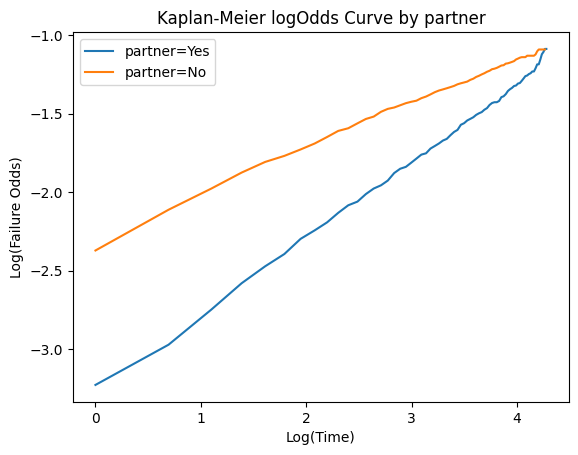

In [16]:
# 初始化Kaplan-Meier拟合器
kmf = KaplanMeierFitter()
# 定义生存分析所需数据：
# T: 持续时间
T = telco_pd['tenure']  
# C: 事件观察值
C = telco_pd['churn'].astype(float)  

# 拟合整体KM曲线
kmf.fit(T, C)

def plot_km_logOdds(col):
    ax = plt.subplot(111)
    
    # 遍历分组
    for r in telco_pd[col].unique():
        # 创建布尔索引筛选当前分组
        ix = telco_pd[col] == r
        
        # 拟合当前分组的KM曲线
        kmf.fit(T[ix], C[ix], label=str(r))
        
        # 获取生存函数
        sf = kmf.survival_function_
        
        # 计算对数风险比（log-odds）：
        # 定义：log((1 - S(t))/S(t)) = log(失败概率/生存概率)
        sf['failureOdds'] = np.log(1 - sf) / sf
        
        # 创建对数时间轴
        sf['logTime'] = np.log(sf.index)  # 时间取自然对数
        
        # 绘制当前分组的曲线
        plt.plot(sf['logTime'], sf['failureOdds'], 
                label=f'{col}={r}')  # 添加分组标签
    
    # 图表装饰
    plt.title(f'Kaplan-Meier logOdds Curve by {col}')
    plt.xlabel('Log(Time)')  # x轴为对数时间
    plt.ylabel('Log(Failure Odds)')  # y轴为对数风险比
    plt.legend()
    plt.show()

# 绘制按伴侣状态分组的曲线
plot_km_logOdds('partner')

,Survival Probability,Monthly Profit,Avg Expected Profit,NPV Profit,Cumulative NPV
Contract Month,,,,,
1.0,1.00,30,30.0,30.00,30.00
2.0,0.87,30,26.1,25.88,55.88
3.0,0.81,30,24.3,23.90,79.78
4.0,0.77,30,23.1,22.53,102.31
5.0,0.74,30,22.2,21.48,123.79
6.0,0.71,30,21.3,20.43,144.22
7.0,0.69,30,20.7,19.69,163.91
8.0,0.67,30,20.1,18.97,182.88
9.0,0.65,30,19.5,18.25,201.13


/tmp/ipykernel_14242/4030028019.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


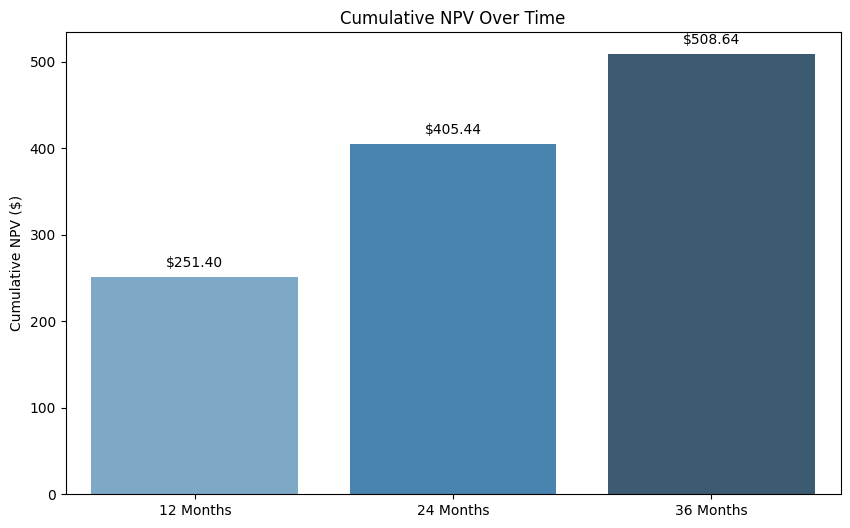

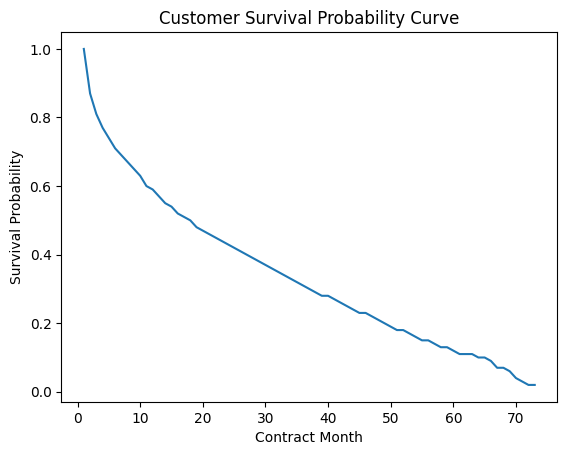

In [14]:
# 需要独热编码的分类变量列
encode_cols = ['dependents','internet_service','onlineBackup','techSupport','paperlessBilling']

# 执行独热编码（生成虚拟变量），保留所有类别（drop_first=False）
encoded_pd = pd.get_dummies(telco_pd, 
                          columns=encode_cols, 
                          prefix=encode_cols, 
                          drop_first=False)

# 选择用于生存分析的列，包含目标变量和特征变量
survival_cols = ['churn','tenure','dependents_Yes',
                'internet_service_DSL','onlineBackup_Yes','techSupport_Yes']

# 创建生存分析数据集，并将目标变量churn转换为浮点型
survival_pd = encoded_pd[survival_cols].assign(
    churn=lambda x: x.churn.astype(float)  # 转换数据类型以适应生存分析模型
)

# 初始化并训练Cox比例风险模型
cph = CoxPHFitter(alpha=0.05).fit(
    survival_pd, 
    duration_col='tenure',   # 生存时间列
    event_col='churn'        # 事件发生指示列
)

# 需要创建控件的特征列表（包含分类变量和利率参数）
cols = ['dependents_Yes', 'internet_service_DSL', 'onlineBackup_Yes',
        'techSupport_Yes', 'partner_Yes', 'internal_rate_of_return']

# 动态生成控件字典（分类变量用下拉菜单，利率用滑动条）
widgets_dict = {
    col: widgets.Dropdown(
        options=[('No',0), ('Yes',1)],  # 二元分类选项
        value=0,                         # 默认值
        description=f"{col.replace('_',' ')}:",  # 人性化显示列名
        disabled=False
    ) if col != 'internal_rate_of_return' else widgets.FloatSlider(
        value=0.10,         # 默认利率值
        min=0.0,           # 最小可选值
        max=1.0,           # 最大可选值
        step=0.01,         # 调整步长
        description='Internal Rate of Return:',
        continuous_update=False  # 只在释放滑块时更新
    ) for col in cols
}

def get_payback_df():
    """计算客户生存分析相关的财务指标
    返回包含以下字段的DataFrame：
    - Survival Probability: 生存概率
    - Monthly Profit: 固定月利润
    - Avg Expected Profit: 预期利润（生存概率*月利润）
    - NPV Profit: 净现值利润
    - Cumulative NPV: 累计净现值
    """
    # 获取所有控件的当前值
    input_values = {col: w.value for col, w in widgets_dict.items()}
    
    # 处理利率参数,将年利率转换为月利率
    irr = input_values.pop('internal_rate_of_return') / 12
    
    # 创建包含输入特征的DataFrame
    df = pd.DataFrame(input_values, index=[0])
    
    # 预测生存概率曲线
    survival_prob = cph.predict_survival_function(df).squeeze()
    
    # 添加初始生存概率
    survival_prob = pd.concat([pd.Series([1.0], index=[0]), survival_prob])
    
    # 构建完整的数据框架
    cohort_df = pd.DataFrame({
        'Survival Probability': survival_prob.round(2),  # 保留两位小数
        'Monthly Profit': 30,  # 假设固定月利润30美元
        'Contract Month': survival_prob.index + 1  # 将索引转换为实际月份
    })
    
    # 计算各项财务指标
    cohort_df['Avg Expected Profit'] = (cohort_df['Survival Probability'] 
                                      * cohort_df['Monthly Profit']).round(2)
    cohort_df['NPV Profit'] = (cohort_df['Avg Expected Profit'] 
                             / (1 + irr) ** cohort_df.index).round(2)
    cohort_df['Cumulative NPV'] = cohort_df['NPV Profit'].cumsum()
    
    # 设置索引并返回指定列
    return cohort_df.set_index('Contract Month')[[
        'Survival Probability',
        'Monthly Profit',
        'Avg Expected Profit', 
        'NPV Profit',
        'Cumulative NPV'
    ]]
    
def plot_cumulative_npv():
    """绘制关键时间点的累计NPV柱状图"""
    df = get_payback_df()
    
    # 定义关键里程碑时间点
    milestones = [12, 24, 36]
    
    # 创建可视化图表
    plt.figure(figsize=(10,6))
    ax = sns.barplot(
        x=[f"{m} Months" for m in milestones],  # x轴标签
        y=df.loc[milestones, 'Cumulative NPV'], # y轴数据
        palette="Blues_d"                       # 颜色主题
    )
    
    # 图表装饰
    ax.set(title='Cumulative NPV Over Time', 
          ylabel='Cumulative NPV ($)')
    
    # 添加数值标签
    for p in ax.patches:
        ax.annotate(f"${p.get_height():.2f}", 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', 
                   va='center', 
                   xytext=(0, 10), 
                   textcoords='offset points')
    plt.show()

def plot_survival():
    """绘制生存概率曲线"""
    sns.lineplot(
        data=get_payback_df().reset_index(),  # 确保x轴正确显示
        x='Contract Month',
        y='Survival Probability'
    )
    plt.title('Customer Survival Probability Curve')
    plt.show()
# 设置Pandas显示选项
pd.options.display.max_rows = 25
# 显示前25个月的详细数据
display(get_payback_df().head(25))
# 生成可视化图表
plot_cumulative_npv()
plot_survival()